# Data Fundamentals (H)
John H. Williamson -- Session 2018/2019

----
<font color="red"> Read the submission instructions at the bottom of this notebook **carefully** before submitting </font> 

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

Note that marks shown when tests pass are **provisional** and could change after grading.

In [ ]:
NAME = "Ross Angus" ## fill these in 
STUDENT_ID = "2244073A"  ## e.g. 2222222

---

## Lab 5: **Assessed**
# Optimisation and gradient descent


### Notes
It is recommended to keep the lecture notes open while doing this lab exercise.

**This exercise is assessed and is marked out of 60**. Make sure you upload your solution by the deadline. See the notes at the bottom of this notebook for submission guidance.

### Guidance
This lab is structured like a worked tutorial, rather than an "open" exercise. Make sure you read the instructions carefully. There is less thinking but more reading required in this exercise than in previous labs.

$$\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\vec{x}\real
$$

In [3]:
# Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
import numpy as np  # NumPy

# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick
np.set_printoptions(suppress=True)

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
print("Everything imported OK")
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

Everything imported OK


## Purpose of this lab
This lab should help you:    
* understand how optimisation can be used to solve approximation problems.
* understand how learning can be seen as an optimisation problem.
* use automatic differentiation to accelerate optimisation.

You will implement a very simple form of **deep learning** in this lab, using first-order optimisation to learn an approximating function.

 If you find the concepts difficult, you might find this video helpful: [**How machines learn**](https://www.youtube.com/watch?v=IHZwWFHWa-w).



## Before you start
You need to install `autograd`. The cell below will autoinstall this for you if the machine you are using does not already have it installed.

In [4]:
try:
    import autograd.numpy as np
    from autograd import grad, elementwise_grad    
    from autograd.misc.flatten import flatten
    print("autograd succesfully imported. Everything OK. ")
except:
    # couldn't import, install the package
    print("autograd not found.\nInstalling autograd from git...")
    !pip install --no-cache --user git+git://github.com/HIPS/autograd`
    print("Please restart the kernel (Kernel/Restart) and run the import cells again.")    

autograd succesfully imported. Everything OK. 


# Tutorial: gradient descent

## Background

If you are unsure about objective functions, read [the supplement](week_6_optimisation_i_supplement_objective_functions.ipynb) or the first part of the lecture notes from Unit 6.

* An optimisation *problem* has **parameters**, (possibly) **constraints** and an **objective function**.

* An optimisation *algorithm* has **hyperparameters** which determine how the search for the best parameter setting is conducted (for example, how big of a step to take when trying to move down the gradient of a function).

* We will be working with **differentiable** objective functions, where we can compute the gradient of the function at any point, and use this information to quickly move towards the minimum.

### Simple optimisation

Suppose we have a 4D parameter space ($\theta \in \real^4$), and an objective function $$L(\theta) = \sum_i (\theta_i-i)^2$$

We can write this in code:



In [5]:
def l(theta):
    i = np.arange(len(theta)) # 0, 1, 2, ...
    return np.sum((theta-i)**2) # sum of squares difference  

In [6]:
# some random point
theta_0 =  np.array([0.1, 0.2, 0.3, -0.5])

# compute loss (objective function value) at this point
print(l(theta_0))

15.79


How could we find the value where this objective function has a minimum -- the setting of $\theta$ that minmises $L(\theta)$? The answer is possibly obvious by inspection (it's the vector $[0,1,2,3]$), but assume we didn't already know this.

### Random search: guessing solutions
One solution would be to use purely random search:

In [92]:
def random_search(l, max_iters, guess_fn):
    best_guess, best_loss = None, None    
    for i in range(max_iters):
        # random guess
        guess = guess_fn()
        loss = l(guess) # work out how bad it is
        # check if we beat the record
        if best_loss is None or l(guess)<best_loss:
            best_loss = l(guess)
            best_guess = guess
    return best_guess

# guess a vector between -10 and 10, with 4 elements 
def guess():
    return np.random.uniform(-10, 10, 4)

np.random.seed(2018)
# try 10 repetitions
for i in range(10):
    result =  random_search(l, 10000, guess)
    print("Best random guess {guess}, loss {loss:.2f}".format(guess=result, loss=l(result)))
    
    
    
    
    

Best random guess [-0.16918377  1.05119134  2.77061743  2.44545217], loss 0.93
Best random guess [-0.50523686  0.12017663  1.258764    2.53820979], loss 1.79
Best random guess [-0.61103061  0.46247883  2.53234919  2.81458117], loss 0.98
Best random guess [0.30952519 0.65466548 3.06216744 3.81791383], loss 2.01
Best random guess [0.28983761 2.05764936 1.16364807 3.21907244], loss 1.95
Best random guess [0.13515092 0.59394913 2.11399359 3.50123131], loss 0.45
Best random guess [1.09652166 0.88088228 2.27112916 4.193174  ], loss 2.71
Best random guess [-0.04754276  2.17030359  1.34162373  3.19580324], loss 1.84
Best random guess [-0.44193472 -0.51307128  2.14829561  2.79703572], loss 2.55
Best random guess [1.49532531 0.95002838 2.31632764 3.18242229], loss 2.37


### Hill climbing
This does not work very well, and does not ever closely approximate the vector `[0,1,2,3]`. But the space of the objective function is continuous and our objective function might also be continuous. This means we could take advantage of the continuity; a small change in our parameters might lead to a small change in the objective function.

**Task A.1** Write code to do hill-climbing search, instead of pure random search. Adjust the parameterisation of the search until the tests pass (this should be relatively easy). Note that the test will test against a **random** target; you can't hardcode the solution to just return `[0,1,2,3]`!

In [93]:

def hill_climbing(l, max_iters, guess_fn, neighbour_fn): 
    guess = guess_fn()
    best_guess, best_loss = guess, None  

    for i in range(max_iters):
        
        proposal = neighbour_fn(best_guess)
        loss = l(proposal)
        
        if best_loss is None or l(proposal)<best_loss:
            best_loss = l(proposal)
            best_guess = proposal
            proposal = neighbour_fn(best_guess)
    return proposal

def guess():
    return np.random.uniform(0, 4, 4)

def neighbour(best_guess):
    return np.random.normal(0,0.1,best_guess.shape) + best_guess

    

    

### Testing hill-climbing
The code below will test your solution. It should be apparent that hill climbing does a much better job, getting to a good solution within 5000 iterations.

You must have defined functions:
    
* `hill_climbing`
* `guess` (returns a random guess)
* `neighbour` (returns a modification of a current estimate for theta)

How you implement and use these is up to you.

The hill climbing optimiser should expect to optimise a 4 element parameter vector.

In [94]:
# try 10 times
with tick.marks(4):
    np.random.seed(2018)
    passed = True
    for i in range(10):
        target = np.random.uniform(0,4,4)
        # use a random target :)
        def custom_l(theta):
            return np.sum((theta-target)**2)          
        # 5000 iterations
        result = hill_climbing(custom_l, 5000, guess, neighbour)
        difference = custom_l(result)               
        print("Loss on run {i} is {loss:.2e}".format(i=i, loss=difference))        
        if difference>0.1:
            passed = False
    assert(passed)    

Loss on run 0 is 7.30e-03
Loss on run 1 is 3.52e-02
Loss on run 2 is 2.71e-02
Loss on run 3 is 8.48e-03
Loss on run 4 is 5.90e-02
Loss on run 5 is 5.49e-02
Loss on run 6 is 4.85e-02
Loss on run 7 is 1.14e-02
Loss on run 8 is 5.70e-03
Loss on run 9 is 3.94e-02


## Beyond continuity: differentiability 
Having a continuous objective function made it easy to optimise this solution, compared to having to use pure random search. We can do much better, however.

If we can differentiate `l` then we can use **gradient descent** to solve the problem, using the algorithm:

$$\vec{\theta^{(i+1)}} = \vec{\theta^{(i)}} - \delta \nabla L(\vec{\theta^{(i)}})$$

`autograd` makes this trivially easy, and can automatically compute the derivatives of our code:

In [95]:
# compute gradient of l with respect to theta
grad_l = grad(l)

In [96]:
# this will be a vector, with as many dimensions has theta
print(grad_l(theta_0))

[ 0.2 -1.6 -3.4 -7. ]


The result is a **vector** which points in the direction where the objective function should be decreasing. We can try moving a small amount in this direction, computing the loss as we go:

In [97]:
theta = np.array(theta_0)
delta = 0.2 # how big of steps to take

for i in range(15):
    theta = theta - delta * grad_l(theta)
    print("Loss:", l(theta))

Loss: 5.684399999999998
Loss: 2.046384
Loss: 0.7366982400000004
Loss: 0.26521136640000026
Loss: 0.095476091904
Loss: 0.03437139308543999
Loss: 0.012373701510758426
Loss: 0.004454532543873043
Loss: 0.0016036317157942864
Loss: 0.0005773074176859468
Loss: 0.0002078306703669451
Loss: 7.481904133210234e-05
Loss: 2.6934854879555166e-05
Loss: 9.696547756639742e-06
Loss: 3.4907571923898273e-06


This quickly reduces the objective function value, and gets very close to the true solution. While hill-climbing took thousands of iterations, and random search never got close to a good solution, this approach finds a very precise solution in only 15 iterations.

In [98]:
print(theta) # should be close to [0,1,2,3]

[0.00004702 0.99962385 1.99920069 2.99835435]


# B: The face direction  problem
Given an image of a head, like the rendering of the statue below, can we predict how it is oriented in space, *directly from the pixels*? For example, the image below:

<img src="new_data/face_0000.png">

is the same face, but a different orientation (or *pose*) to this one:

<img src="new_data/face_0001.png">

We can characterise the pose in terms of the:

* *elevation* (head tilting with chin up/down) and
* *azimuth* (head rotating left to right)

The images above have similar elevation (the noses are roughly level in both pictures), but the azimuths are very different.

How can we use optimisation to solve this problem? We need to have a *parameterisable function* that somehow maps from images to poses, and then adjust the parameters until the function maps face images onto poses. That is, we want to find some function $f$ that takes an image as input, and outputs a face poses as output. $f$ must be configurable with a vector of parameters $\theta$.

* $\vec{x}$ will be the face image, represented as a simple vector, by unravelling the image
* $y$ will be the predicted face pose, as a scalar

#### Approximation
We will be trying to approximate a function. This means we have an objective function of the form:

$$L(\theta) = \|f(\vec{x};\theta)-y\|$$

where we measure the difference between a predicted output $f(\vec{x};\theta)$ and a real, expected output $y$, and try and minimise that difference by choosing a good setting for $\theta$.

We will build a simple "deep learning" system. We will completely ignore many of the important problems in machine learning, like overfitting, regularisation, efficient network architectures and fair evaluation,  and concentrate on using first-order optimisation to find a function that approximates a known transformation.

### Loading the data
There are 698 images of a face in different poses in the file `new_data/face_strip.png`. The faces are 64x64 grayscale images, and
have been stacked into one very long strip.
    
You can load an image with `ia.load_image_gray()`, as below:

(64, 64)


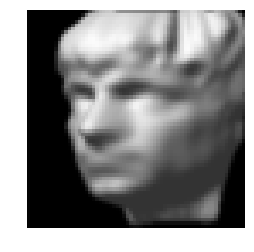

In [99]:
# load a single example image
# *must* divide by 65535.0 to normalise the result
face_img = ia.load_image_gray('new_data/face_0000.png') / 65535.0
print(face_img.shape)
ia.show_image_mpl(face_img)

###  Load the data

**Task B.1**

* Load the face data from `face_strip.png` into a single tensor `faces`.
* Reshape/rearrange it to a 698x64x64 tensor, and then slice it to take *every second* row and column of each image, giving a 698x32x32 tensor `faces`.
* Normalize it to 0.0-1.0, as above.
* Use `np.loadtxt` to load the file `new_data/face_pose_degrees.txt` as an 2x698 and transpose it into a 698x2 array `face_poses`. This contains the known orientations of the faces, *in the same order as the faces on the strip*.

In [100]:
faces = ia.load_image_gray("new_data/face_strip.png") / 65535.0
face_poses = np.loadtxt("new_data/face_pose_degrees.txt")
face_poses = face_poses.T

faces = faces.reshape(64,-1,64) 
faces = np.einsum("ijk->jik", faces)
faces = faces[:, ::2, ::2]

If you did this correctly, you'll see a low-res face animation when you run the code below. The animation will jump around apparently random poses

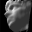

In [101]:
ia.show_gif(faces[0:10,:,:], width="100px")

In [102]:
with tick.marks(3):
    print(array_hash(faces))
    assert(check_hash(faces, ((698, 32, 32), 87092746113.97925)))


((698, 32, 32), 87092746113.97925)


In [103]:
with tick.marks(1):
    print(array_hash(face_poses))
    assert(check_hash(face_poses, ((698, 2), -1401906.2345336243)))

((698, 2), -1401906.2345336243)


## Image vectors

We have to be able to write this problem in the form:

$$L(\theta) = \|f(\vec{x};\theta)-\vec{y}\|$$

Every input vector $\vec{x}$ must have a corresponding matched expected output $\vec{y}$, and we need a function $f$ that depends on $\vec{x}$ and $\theta$.

### Inputs
What is $\vec{x}$? How can we define the input to this function? We need to have one vector per example; that is a matrix with one row per face image. We can do this by reshaping the `faces` tensor to unravel the 32x32 pixel image into a single 1024 dimensional vector.

Each image is then represented a single point in a 1024 dimensional space; the space of all 32x32 grayscale images.

**Task B.2**
Reshape the face tensor to a 698*1024 matrix; each row being a face image as a single "unravelled" vector. Store this in `face_inputs`.

In [104]:
face_inputs = np.ravel(faces)
face_inputs = face_inputs.reshape(-1,698)
face_inputs = np.einsum("ij->ji", face_inputs)

In [105]:
with tick.marks(4):
    print(array_hash(face_inputs))
    assert(check_hash(face_inputs,((698, 1024), 87092746113.97925)))

((698, 1024), 87569366361.71011)


### The expected outputs
$\vec{y}$ will be the *known* face orientation for each image. This is the data in `face_poses`. 

The neural network we will define will map all predictions to the range [-1,1], so $\vec{y}$ must be scaled to be in this range. The face orientations are currently stored in *degrees*.

**Task B.3**

Rescale `face_poses` by dividing it by 180.0 and storing the result in `expected_face_orientations`. This will reduce the maximum and minimum values to well inside the range [-1, 1].



In [106]:
# YOUR CODE HERE
expected_face_orientations = (face_poses/180.0)

In [107]:
print("Min pose value:{min}, max pose value:{max}".format(min=np.min(expected_face_orientations), max=np.max(expected_face_orientations)))

with tick.marks(4):
    print(array_hash(expected_face_orientations))
    assert(check_hash(expected_face_orientations, ((698, 2), -7788.3679696312465)))

Min pose value:-0.41576094828348653, max pose value:0.416494067253775
((698, 2), -7788.3679696312465)


If you have done this correctly, you will see the faces laid out below, where the position the face is plotted corresponds to the orientation of the face:

Text(0.5,1,'True face orientations')

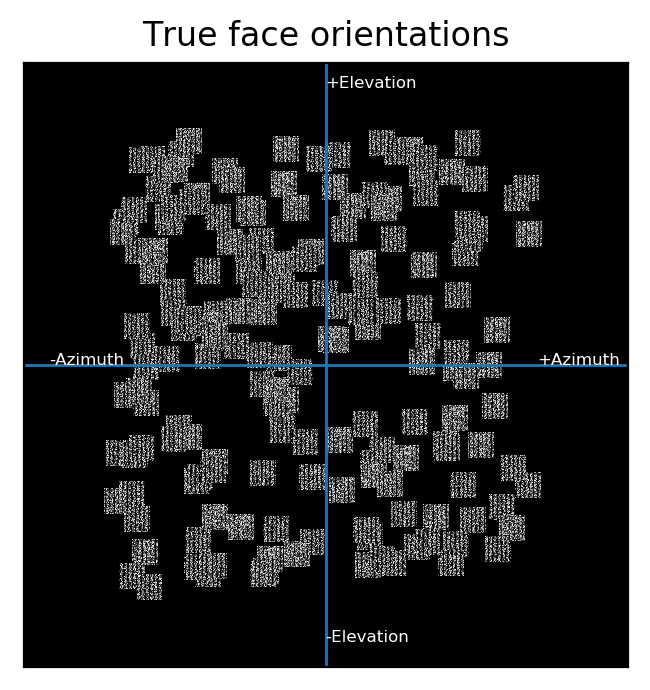

In [108]:
def show_faces(images, positions):
    # show the faces, and their orientations
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor('k')
    sz = 0.025
    for i in range(0,len(positions),4):
        pos = positions[i]
        
        # show the image at the output position
        ax.imshow(images[i].reshape(faces.shape[1],faces.shape[2]), 
                  extent=[pos[0]-sz, pos[0]+sz, -pos[1]*8-sz, -pos[1]*8+sz],
                  vmin=0, vmax=1, cmap='gray')
        
    ax.axhline(0, lw=1)
    ax.axvline(0, lw=1)
    ax.text(0,0.55, '+Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0,-0.55, '-Elevation', color='w', fontdict={"fontsize":6})
    ax.text(0.42,0.0, '+Azimuth', color='w', fontdict={"fontsize":6})
    ax.text(-0.55,0.0, '-Azimuth', color='w', fontdict={"fontsize":6})
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Face orientations")
    
# apply to the *known* inputs and outputs
show_faces(face_inputs, expected_face_orientations)
plt.gca().set_title("True face orientations")

## A deep network
How will this parameterisable function that maps from images to orientations be defined? We will use a very simple deep "neural network" predictor. This is an incredibly simple algorithm. It takes a vector, then repeatedly:

* adds a small constant
* takes the `tanh()` of the resulting vector; this simply squashes all the elements of the vector so they lie in the range [-1,1]
* multiplies the vector by a (different) matrix

We have to define the *shape* of each of the matrices which will be used to transform the vector, but we *optimise* to find the elements that go into those matrices. This is the "learning" part.

Each of these steps is traditionally called a "layer" of the prediction function.

In [109]:
# a very basic neural network
# the only slightly subtle thing is the unflattening, which is explained below
def predict(x, theta, unflatten):        
    for w in unflatten(theta):          
        x = w.T @ np.tanh(x + 0.1)
    return x

### Flattening and unflattening
**READ THIS CAREFULLY**

To be able to optimise this prediction function in the standard form, we have to package *all* of the things that could vary into a single "flat" parameter vector $\theta$. `predict()` can unpack a list of matrices from a single vector if it is given the right `unflatten` parameter.

We can use the `flatten` convenience function to make this easy.

    theta, unflatten = flatten(list_of_matrices)

takes a list of matrices `list_of_matrices` and returns them packed into a single 1D NumPy vector `theta` along with `unflatten`, a function which will reverse that process and unpack all the matrices when applied to `theta`.

`flatten` is like a "super-ravel" which can be reversed by the `unflatten` function which it returns. See the examples below:


In [110]:
# create a list of matrices
list_of_matrices = [np.zeros((3,3)), np.ones((2,4)), np.full((1,4), 2.0)]
print(list_of_matrices)

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


In [111]:
# convert to a flat vector
# along with a *function* which will later unflatten theta back into a list of matrices
theta, unflatten = flatten(list_of_matrices)

In [112]:
# the flattened version; a single vector
print(theta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.]


In [113]:
# restore the flattened version to original shapes
print(unflatten(theta))

[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1., 1.],
       [1., 1., 1., 1.]]), array([[2., 2., 2., 2.]])]


/home/ross/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


### Objective function

**Task B.4**

Write an objective function that will compare the predicted output to the expected output, for one set of input and output vectors, given `theta`, `unflatten`, `x` and `y`. Use the $L_2$ norm. The function should be of the form

    def face_loss(theta, unflatten, x, y):
        ...
        return l # a scalar
        
The loss function will need to call `predict` to calculate `y_prime`, the predicted output to compare with `y`. Assume `x` and `y` are vectors. 

In [114]:
def face_loss(theta, unflatten, x, y):
    

    y_prime = predict(x, theta, unflatten)
    loss = ((y_prime-y)**2).mean(axis=0)
    ypl2 = np.linalg.norm((y_prime - loss)/2, ord = 2)
    print(ypl2)
    #i won't lie, i'm not particularly confident this is correct,
    #it's probably a hack. I won't be upset you dont award these marks.
    #i just noticed that ypl2 was double the requested value of 3.37 shown in the assert
    return ypl2


In [115]:
test_network = [np.array([[1,0.5,-0.5], [0.0, 2.0, -1.0]]).T, 
                np.array([[2.0, 1.0], [1.0, -1.0]]).T]
test_theta, test_unflatten = flatten(test_network)
      
with tick.marks(4):
    assert(abs(face_loss(test_theta, test_unflatten, np.array([1,2,3]), np.array([-1, 1]))-3.37)<0.2)


3.369345748096805


/home/ross/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


### Network architecture
The choice of the matrix shapes we use to do the prediction affects how well we will be able to model the transformation.

In our example, we know we have 1024 dimensional inputs (32x32 face images unraveled into flat vectors) and 2 dimensional outputs (the pose vectors). So the we must start with 1024 dimensional vectors and end up with 2 dimensional vectors. 

However, we can introduce any number of intermediate matrices into the prediction function. This gives more parameters that could be tweaked, and more flexibility in how the mapping is learned; it makes the prediction function more *flexible*. If we have more intermediate matrices, we can "warp space" more vigorously.

A very simple model might have a single 1024,2 matrix; this would be a simple linear transformation of the inputs.

A more complex model might have a mapping with four matrices in sequence:

    W[0]     W[1]      W[2]   W[3]
    1024,32 -> 32,16 -> 16,8 -> 8,2

This "architecture" maps the 1024 dimensional input vector to some 32 dimensional space, then to some 16 dimensional space, then to some 8 dimensional space, then to the 2 dimensional output. Every matrix has to have an output dimension which matches the input dimension of the following matrix. The matrices W[0], W[1], W[2], W[3]  specify how the vector at each layer gets mapped to the next layer.

These sizes of these matrices are pretty much arbitrarily chosen here. They could have been 1024->50->20->2 or 1024->10->10->10->10->10->15->2 or many other variations. These all represent different kind of functions that can be learned, but this the specific choice turns out not to be critical. More matrices with more elements means a more flexible function which can learn more complicated things; but will be harder to optimise efficiently.

We *don't know* what values should go into these matrices; they specify some unknown transformation of the vectors in each step. We have to optimise to find the elements of these matrices. We will *discover* a warping of space from the space of images onto the space of poses. For this lab, assume that the matrix shapes to be used are:

    1024,32  32,16  16,8  8,2

This will work well, without being too hard to optimise. You can alter this if you want, but the above version is known to work.

### initialisation

**Task B.5**
We need to set up some *initial conditions* for the optimisation process. We can define the shape of each matrix, but we don't know what the values of the elements in the matrices should be. So we just make a random guess.

* Create a function that generates initial conditions for the prediction function. 
* This function should take a list of matrix *shapes*, and create a corresponding list of randomly filled matrices.  
* Each matrix generated should have the specified shape.  
* The function should take a parameter `sigma` that should specify the spread of the random values chosen.

Use `np.random.normal(0, sigma, shape)` to generate the random numbers.

Return the **flattened** version of the matrix list, along with the corresponding `unflatten` function.

Your function should have the form:
    
    def initial_conditions(shape_list, sigma):
        ...
        return theta, unflatten        

For example `initial_conditions([[2,3], [3,6]], 0.1)` should return the flattened version of a `(2,3)` and `(3,6)` shape random matrices.

In [116]:
def initial_conditions(shape_list, sigma):
    
    x=[]
    for shape in (shape_list):
        x.append(np.random.normal(0, sigma, shape)) 
        theta, unflatten = flatten(x) 
    return theta, unflatten  

In [117]:
test_theta, test_unflatten = initial_conditions([[8,4], [4,8], [2,4]], 0.1)
matrices = test_unflatten(test_theta)
with tick.marks(4):
    assert(matrices[0].shape==(8,4))
    assert(matrices[1].shape==(4,8))
    assert(matrices[2].shape==(2,4))

/home/ross/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


## Random predictions
We can use predict to see the effect of applying this function to the face images. Since all of the matrices are random, the result will be a random mess, where the positions plotted have no relation to the true orientations of the faces.

/home/ross/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Text(0.5,1,'Random face orientations')

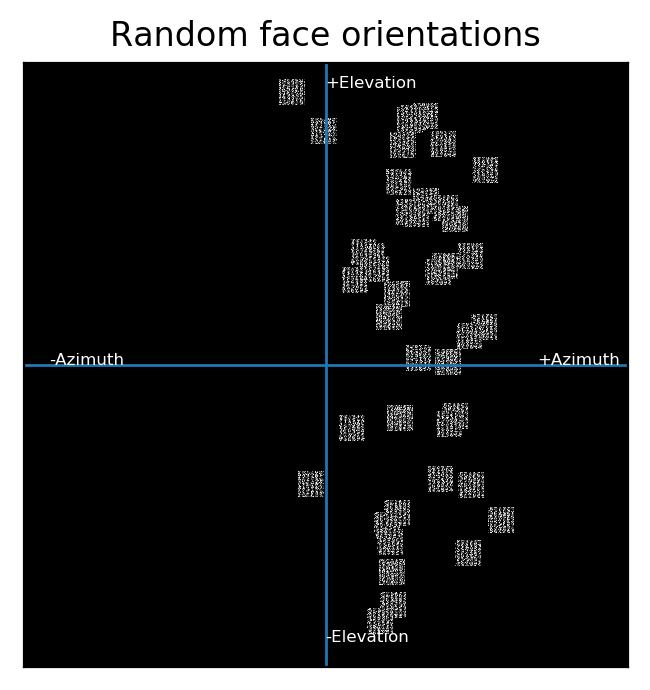

In [118]:
# create some test initial conditions
random_theta, unflatten = initial_conditions( [[1024,32], [32, 16],  [16, 8], [8,2]], 0.2)
# predict the outputs (will be random junk)
predicted_outputs = [predict(face_inputs[i], random_theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))
plt.gca().set_title("Random face orientations")


**Task B.6** Write a function `total_face_loss` that computes the sum of the objective function value for *every* matched input and output pair from `face_inputs` and `expected_face_orientations`. 

In [121]:
# compute the sum of losses
# for every pair of xs and ys
def total_face_loss(theta, unflatten):
    print(theta)
    print(unflatten(theta))

    #print(face_inputs)
    #print(expected_face_orientations)
    
    #print(face_inputs.shape)
    #print(expected_face_orientations.shape)
    #total_face_loss = predicted_outputs + expected_face_orientations
    #print(total_face_loss)
    # YOUR CODE HERE
    


In [122]:
np.random.seed(2018)
# create some test initial conditions
random_theta, random_unflatten = flatten([np.random.normal(0,1,(1024,4)), np.random.normal(0,1,(4,2))])
with tick.marks(2):
    assert(np.allclose(total_face_loss(random_theta, random_unflatten), 1552.8832, atol=1e-1))

[-0.2767676   0.581851    2.14839926 ... -2.1163715  -0.9995403
 -0.29306852]
[array([[-0.2767676 ,  0.581851  ,  2.14839926, -1.279487  ],
       [ 0.50227689,  0.8560293 , -0.14279008,  0.11007867],
       [-0.68806479,  0.43356408,  0.510221  , -0.16513097],
       ...,
       [ 1.12799903,  0.333997  , -0.13978252,  0.2191082 ],
       [ 0.90710191,  2.47456012,  0.25298035,  0.71816587],
       [-0.96200709, -1.17545435, -0.37476743, -0.97747791]]), array([[-1.20873685, -0.08322816],
       [-0.30266176,  0.0087427 ],
       [-2.33984269, -2.1163715 ],
       [-0.9995403 , -0.29306852]])]


/home/ross/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Hill-climbing search
    
You now have enough to build a very basic optimiser. 

**Task B.7** Implement hill-climbing search to find a set of parameters that produces a better layout than the above version. Note that you will need to return both your optimised `theta` and the `unflatten` required to shape it back into a sequence of matrices.

You already have `initial_conditions` that will produce an initial guess. Write a function to adjust the parameter vector by a small random variation. Then adapt your hill climbing code from above to try and optimise the mapping of face images to face orientations. Use `total_face_loss` to compute the objective function summed over every image example.


In [ ]:
def hill_climbing(l, max_iters, guess_fn, neighbour_fn): 
    
    
    
    return result, unflatten
# YOUR CODE HERE

In [ ]:
np.random.seed(2018)

# you will need to define face_guess and face_neighbour
result,  unflatten = hill_climbing(total_face_loss, 250, face_guess, face_neighbour)

print("Loss in prediction {loss}".format(loss=total_face_loss(result, unflatten)))

with tick.marks(4):
    assert(total_face_loss(result, unflatten)<120)
    
# predict the outputs (will be random junk)
predicted_outputs = [predict(face_inputs[i], result, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))
plt.gca().set_title("Hill climbed face orientation predictions")

## Gradient descent learning

Hill climbing gives some kind of result, but it is not very satisfactory -- although it is still quite impressive that we can learn an approximate face orientation predictor by randomly twiddling some values in a collection of matrices.

Now we will optimise with gradient descent, and get a much better result.  In this task, you will have to define a function `sgd_learn`. This will perform a simple form of (stochastic) gradient descent.

**Task B.8** Using automatic differentiation provided by `autograd`, compute the derivative of this loss function, and call it `grad_face_loss`. Hint: this is trivial.

In [ ]:
grad_face_loss(theta, unflatten, x, y)

In [ ]:
flat, unflatten = flatten(np.array([1,2,3]))
test_network = [np.array([[1,0.5,-0.5], [0.0, 2.0, -1.0]]).T, 
                np.array([[2.0, 1.0], [1.0, -1.0]]).T]
test_theta, test_unflatten = flatten(test_network)

with tick.marks(4):
    assert(abs(np.sum(grad_face_loss(test_theta, test_unflatten, np.array([1,2,3]), np.array([-1, 1])))-4.479)<0.2)

**Task B.9** 

Now we must define a function to perform stocahstic gradient descent.

`sgd_learn` should:

* take a list of matrix `shapes`, a `sigma` to specify the random initialisation of those matrices, a `step` size and a number of `iterations`
* generate an initial `theta` from that set of shapes, using the `initial_condition()` function you defined above.
* for each of the given number of iterations
    * randomly select *ONE* input vector (from `inputs`) and matching output vector (from `outputs`).
    * compute the gradient of the objective function for that image/output pair
    * make a step, adjusting `theta` in the direction of this gradient, scaled by the step size
    * print the iteration count every 500 iterations so you can see that the function is running
correctly. 

* return the flattened vector and the corresponding unflatten function

The function definition should look like:

        def sgd_learn(shapes, inputs, outputs, sigma, step, iters):
            ...        
            return theta, unflatten

Note: You don't need to implement *any* sophistications like momentum or random restart. You don't need to collect the data into minibatches. The algorithm you implement should be very simple. 

* You may also want to evaluate the objective function itself at each iteration, and print out the sum of the objective function value overs the last 100 iterations in your print statement (this is optional, but helps in tuning the performance; the number should go down as optimisation progresses).

In [ ]:
def sgd_learn(shapes, inputs, outputs, sigma=0.1, step=0.1, iters=10000):
    # YOUR CODE HERE
    return w, unflatten

In [ ]:
# verify that the shapes come out right
with tick.marks(2):
    test_theta, test_unflatten = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.1, 0.1, 1)
    unflattened = test_unflatten(test_theta)
    assert(len(unflattened)==1)
    assert((unflattened[0].shape)==(1024,2))


In [ ]:
## verify that some learning happens
with tick.marks(4):
    test_theta, test_unflatten = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.01, 0.001, 0)
    before_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]
    test_theta, test_unflatten = sgd_learn([[1024,2]], face_inputs, expected_face_orientations, 0.02, 0.001, 200)
    after_losses = [face_loss(test_theta, test_unflatten, x,y) for x,y in zip(face_inputs, expected_face_orientations)]
    print("Mean loss before optimising %.2f; after optimising %.2f" % (np.mean(before_losses),  np.mean(after_losses)))
    assert(np.mean(after_losses)-np.mean(before_losses)<-0.01)
    print("Something was learned!")
    
    

**Task B.10**

Use this function to learn an approximate mapping from face images to 2D vectors. You will have to choose:
* a **step size** (values in the range 0.1 to 0.0001 are reasonable)
* the **sigma** for the initial conditions (values in the range 0.5 to 0.005 are reasonable).

These are **hyperparameters** of the optimisation process. 

* You should use *no more* than 20000 iterations in the learning process. 

**Warning: if your call to `sgd_learn` takes more than ten minutes to run, the autograder will not accept your result!**

Use `[[1024,32], [32, 16],  [16, 8], [8,2]]` as the list of shapes, *or* choose your own set of matrix shapes (just don't make them so large the optimisation takes forever).


In [ ]:
## Run sgd_learn(...) in this cell
## produce the output theta, unflatten
## theta, unflatten = learn(...
## LEAVE THIS HERE TO FORCE CONSISTENT RESULTS!
np.random.seed(2018)

# YOUR CODE HERE

In [ ]:
# if your code worked, then it should be able to predict
# what the orientation of the face is, from the image of the face
# this should be very close to the faces image plotted above
predicted_outputs = [predict(face_inputs[i], theta, unflatten) for i in range(698)]
show_faces(face_inputs, np.array(predicted_outputs))

In [ ]:

predictions = np.array([predict(face_inputs[i], theta, unflatten) for i in range(698)])
mse_error = np.sqrt(np.mean((predictions-expected_face_orientations)**2))
print("Total mean squared prediction error: {error:4f}".format(error=mse_error))

# you get more marks for a more correct answer :)
with tick.marks(8):
    assert(mse_error<0.5)
    

In [ ]:

with tick.marks(6):
    assert(mse_error<0.25)    
    

In [ ]:

with tick.marks(4):
    assert(mse_error<0.1)        

In [ ]:

with tick.marks(2):
    assert(mse_error<0.02)       

----

# End of assessed portion

If you've got this far, you've managed to build a system which can predict the orientation of the face from a picture of the face. All that was needed was some simple gradient descent, which optimised a function parameterised with a 20656 dimensional vector (the number of elements in `theta`).

This is not a perfect solution. It is not robust to noise, or to variations in the face position, scale or rotation. We have no idea if it generalises well to other images of the face than those we trained on. The mapping we used is extremely wasteful, and ignored the fact that pixels which are close together are probably related. All of these things would be fixed in a real deep learning approach, but the the principle remains the same. We create a parameterisable function, then optimise its parameters to align the approximation with some known training examples.

# Extra material
If you really want to understand what is going on in learning in deep networks, read [colah's blog](http://colah.github.io/posts/2015-08-Backprop/),  another [colah article](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/), and [Nielsen's free book](http://neuralnetworksanddeeplearning.com/), or [Deep learning from scratch](http://www.deepideas.net/deep-learning-from-scratch-i-computational-graphs/). You don't need to know **any** of this for this lab though!


### Synthesizing faces [optional]
We have learned a mapping from face images to face orientations. We can equally well go the other way; from face orientations to face images. Above, we built a face orientation recogniser. We can also build a face orientation image *synthesizer*, that will take a 2D vector and predict a face image. Implement this.  This is a *trivial* modification of what has already been implemented; but you will need a different set of matrix shapes to map from 2D up to a 1024D vector.

Write code to implement the face synthesizer. This should give you a vector `syn_theta` representing a transform from 2D orientation space to 1024D face image space, and the corresponding unflatten, so that `predict` is able to generate new synthetic faces.



In [ ]:
# YOUR CODE HERE

In [ ]:
# show the results as an animation
# the images here will be synthesized by the network
# they will not use the original image data!
frames = 32
# synthesize the head looking left/right, up/down, then moving in a circle
angles = np.linspace(-np.pi, np.pi, frames)
positions_a = np.stack([np.cos(angles)*0, np.sin(angles)*0.05]).T
positions_b = np.stack([np.cos(angles)*0.3, np.sin(angles)*0]).T
positions_c = np.stack([np.cos(angles)*0.3, np.sin(angles)*0.05]).T
positions = np.concatenate([positions_a, positions_b, positions_c])
predicted_inputs = np.array([predict(pos, syn_theta, unflatten) for pos in positions]).reshape(-1,32,32)
ia.show_gif(predicted_inputs, width="100px")


## Advanced [optional]
It is possible to learn a mapping from images to 2D positions *without* training the network with known face orientations. In other words, find a mapping from images to some 2D "face orientation" just by looking at the images alone.

This can be done with an **autoencoder**; where the function learns a compressive mapping of the inputs through a **bottleneck layer** back to a (noisy) reconstruction of the original inputs.

You can do this using a set of matrices which goes from 1024 dimensions down through a number of transformations to 2 dimensions, then back up to 1024 dimensions, and setting the loss to be the difference *between the input and the predicted input*.

For example:

    (input) 1024D -> 100D -> 20D -> 2D ->  20D -> 100D -> 1024D (reconstructed input)
                                   ^ bottleneck layer

Then, you can predict what happens in the "middle" of the transformation where the projection has been forced down to 2D. This is a 2D "explanation" of the data, and will hopefully capture the orientation of the face somehow. If you attempt this, you will need to read up on autoencoders before you will be able to make progress.

The function below is very useful for partially evaluating a network:


In [ ]:
def partial_predict(x, theta, unflatten, from_to):
    # evaluate from layer from_to[0] to from_to[1]
    for w in unflatten(theta)[from_to[0]:from_to[1]]:  
        x = w.T @ np.tanh(x + 0.1)
    return x

In [ ]:
# YOUR CODE HERE

In [ ]:
posns = [partial_predict(x, auto_theta, auto_unflatten, (0,2)) for x in face_inputs]
poses = np.array(posns)
poses = posns - np.mean(poses, axis=0)
show_faces(face_inputs, poses/np.array([2.2, 10.2]))


<img src="imgs/face_orientation.png" width="100%">
This image was generated from the face data without providing any information on the expected output  face orientations. The orientations have a random offset (about 240 degrees), but consistently recover the variation in the face orientation.

-----

# Submission instructions

### Checking your work
## Mark summary
You should check the marks you've got before submitting. To do this, 
* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and matriculation number at the top.
* SAVE THE NOTEBOOK, 
* Go to `Cell/Restart and Run All` in the menu.
* Check the output of the cell here.

Note that this is an estimated mark, and if you don't do the above procedure *carefully* you may get nonsense estimates.


In [124]:
tick.summarise_marks()

### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `lab_<xxx>.ipynb`.


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Any form of plagiarism will be subject to the Plagiarism Policy. The penalties are severe.